In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pathlib
import os
import cv2

In [3]:
rootpath = './malaria'

In [4]:
def show_bound_boxes(image, boxes, labels=None, tensor=False, color="green", title="Bounding Boxes", cv = True, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    if tensor: 
        image = image.detach().numpy().transpose(1, 2, 0)
    if cv:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.title.set_text(title)
    if labels is not None:    
        for box, label in zip(boxes, labels):
            color = color if label == 1 else "red"
            width, height = box[2] - box[0], box[3] - box[1]
            bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
            ax.add_patch(bounding_box)
    else:
        for box in boxes:
            color = color
            width, height = box[2] - box[0], box[3] - box[1]
            bounding_box = patches.Rectangle((box[0], box[1]), width, height ,edgecolor=color, facecolor='none')
            ax.add_patch(bounding_box)
        
def show_tensor(tensor): 
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

In [5]:
def format_objects(objects):
    boxes = []
    labels = []
    categories = []
    for cell in objects:
        if cell['category'] != 'difficult':
            bbox = cell['bounding_box']
            x1 = bbox['minimum']['c']
            y1 = bbox['minimum']['r']
            x2 = bbox['maximum']['c']
            y2 = bbox['maximum']['r']
            boxes.append([x1,y1,x2,y2])
            category = cell['category']
            categories.append(category)
            if category=='red blood cell' or category=='leukocyte':
                label = 1
            else:
                label = 0
            labels.append(label)
    return {'boxes':np.array(boxes), 'labels':np.array(labels), 'categories':np.array(categories)}
           

# Loading Data

In [6]:
df1 = pd.read_json('./malaria/training.json')
df1.head()

,image,objects
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':..."
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ..."
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ..."
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ..."
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ..."


In [7]:
print(df1['image'][0])

{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af', 'pathname': '/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png', 'shape': {'r': 1200, 'c': 1600, 'channels': 3}}


In [8]:
df1['path'] = df1['image'].apply(lambda x: x['pathname'])
df1['shape'] = df1['image'].apply(lambda x: x['shape'])
df1['shape'] = df1['shape'].apply(lambda x: (x['r'], x['c'], x['channels']))
df1['objects'] = df1['objects'].apply(format_objects)

In [9]:
df1.head()

,image,objects,path,shape
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"{'boxes': [[1440, 1057, 1540, 1158], [1303, 86...",/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"(1200, 1600, 3)"
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"{'boxes': [[735, 734, 834, 832], [1283, 939, 1...",/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,"(1200, 1600, 3)"
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"{'boxes': [[1027, 724, 1136, 834], [1155, 287,...",/images/6b14c855-8561-417c-97a4-63fa552842fd.png,"(1200, 1600, 3)"
3,{'checksum': '8a111dffacfa433029492780b9535091...,"{'boxes': [[1421, 563, 1545, 656], [324, 208, ...",/images/13099edb-35d9-438f-b093-2cf2ebf9d255.png,"(1200, 1600, 3)"
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"{'boxes': [[688, 618, 810, 744], [1035, 689, 1...",/images/2559636b-f01a-4414-93da-210c3b12d153.png,"(1200, 1600, 3)"


# cv2

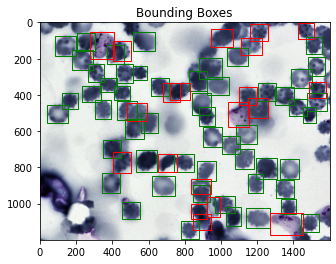

In [10]:
img = cv2.imread(rootpath + df1['path'][0])
objects = df1['objects'][0]
show_bound_boxes(img, objects['boxes'],  objects['labels'])

In [11]:
def draw_contour_blank(size, contours, color=(100, 255, 255), fill=False):
    x, y = size
    img = np.zeros((x, y, 3), np.uint8)
    thick = -1 if fill else 3
    cv2.drawContours(image=img, contours=contours, contourIdx=-1, color=color, thickness=thick)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

def contour_to_boxes(contours):
    boxes = []
    labels = []
    for contour in contours:
        box = list(cv2.boundingRect(contour))
        boxes.append(box)
        labels.append(1)
    return {'boxes':np.array(boxes), 'labels':np.array(labels)}

In [121]:
def contours_to_boxes(contours, erd_kernel=(5,5), erd_iter=10, area_filter=-1):
    kx, ky = erd_kernel
    kx = kx//2
    ky = ky//2
    boxes = []
    for contour in contours:
        box = list(cv2.boundingRect(contour))
        box[0] -= ky * erd_iter
        box[1] -= kx * erd_iter
        box[2] = box[0] + box[2] + ky * erd_iter * 2
        box[3] = box[1] + box[3] + kx * erd_iter * 2
        boxes.append(box)
    if area_filter==False or area_filter < 0:
        return np.array(boxes)
    else:
        result=[]
        for box in boxes: 
            area = (box[2] - box[0]) * (box[3] - box[1])
            if area < area_filter and area >= 1:
                result.append(box)
        return np.array(result)


def get_boxes(img, size=(1200,1600), erd_kernel=(5,5), erd_iter=10, area_filter=25000, BGR=True):
    x, y = size
    if BGR:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    th = 255-th
    flood = cv2.copyMakeBorder(th, 1,1,1,1, cv2.BORDER_CONSTANT, value=0)
    cv2.floodFill(flood, np.zeros((x+4, y+4), np.uint8), (0, 0), 255)
    flood = flood[1:x+1, 1:y+1]
    flood = 255-flood
    filled = th | flood
    # plt.imshow(cv2.cvtColor(filled, cv2.COLOR_BGR2RGB))
    if isinstance(erd_kernel, int):
        erd_kernel = (erd_kernel, erd_kernel)
    kernel = np.ones(erd_kernel, dtype=np.uint8)
    erd = cv2.erode(filled, kernel, iterations = erd_iter)
    # plt.imshow(cv2.cvtColor(erd, cv2.COLOR_BGR2RGB))
    contours, hierarchy = cv2.findContours(erd, cv2.RETR_EXTERNAL, 2)
    boxes = contours_to_boxes(contours, erd_kernel, erd_iter, area_filter)
    return boxes

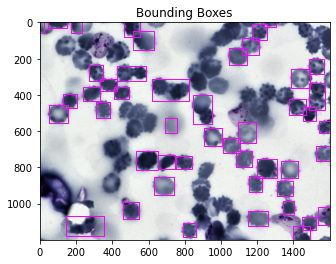

In [13]:
boxes = get_boxes(img, erd_kernel=(5, 5), erd_iter=10)
show_bound_boxes(img, boxes, color="magenta")

# test

In [14]:
def try_image(index = 0, erd_kernel=(5,5), erd_iter=10, area_filter=25000, root=rootpath):
    print("i =", index)
    fig, ax = plt.subplots(1,2, figsize=(12, 16))
    img = cv2.imread(root + df1['path'][index])
    objects = df1['objects'][index]
    x,y,c = df1['shape'][index]
    show_bound_boxes(img, objects['boxes'],  objects['labels'], title="Ground Truth", ax=ax[0])
    boxes = get_boxes(img, (x,y), erd_kernel, erd_iter, area_filter, BGR=True)
    show_bound_boxes(img, boxes, title="OpenCV", ax=ax[1], color="magenta")
    return boxes

i = 0
i = 10



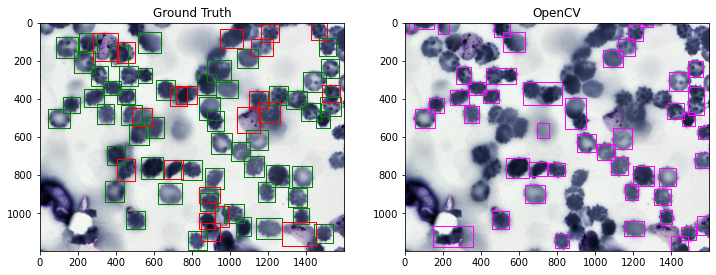

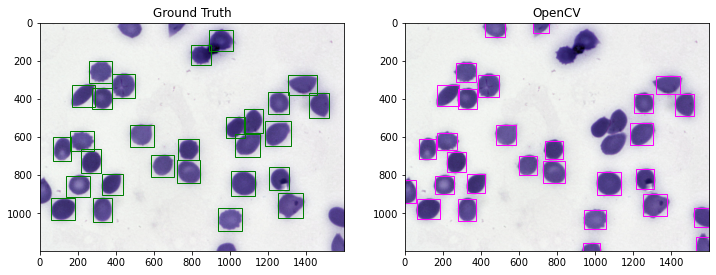

In [15]:
try_image(0)
try_image(10)
print('')

# cnn

In [16]:
# from sklearn import svm
# from sklearn.metrics import classification_report,accuracy_score

In [150]:
def get_img_targets(index, equalize=True):
    img = cv2.imread(rootpath + df1['path'][index])
    objects = df1['objects'][index]
    labels = objects['labels']
    boxes = objects['boxes']
    truth = []
    if equalize:
        infected = np.count_nonzero(labels-1)
        count = 0
        for box, label in zip(boxes, labels):
            if label==0 or count<infected:
                cell = img[box[1]:box[3], box[0]:box[2], :]
                truth.append((cell, label))
                if label==1:
                    count += 1
    else:
        for box, label in zip(boxes, labels):
            cell = img[box[0]:box[2], box[1]:box[3], :]
            truth.append((cell, label))
    return truth

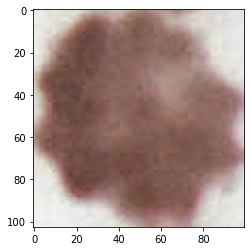

In [18]:
truth = get_img_targets(0)
plt.imshow(truth[1][0])

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 

In [19]:
len(df1)*0.7

845.5999999999999

In [20]:
from PIL import Image
def resize(image, size): 
    resized = Image.fromarray(image).resize(size, resample=Image.BOX)
    return np.array(resized)

In [26]:
data = []
for i in range(1208):
    data += get_img_targets(i, equalize=True)
df = pd.DataFrame(data, columns=['image', 'label'])

In [42]:
train_df = df.copy()[:2776]

In [29]:
train_df.to_pickle('./cv_cnn/cnn_train.pickle')

In [44]:
train_df.head()

,image,label
0,"[[[235, 238, 236], [237, 240, 238], [238, 241,...",1
1,"[[[233, 234, 225], [236, 233, 226], [225, 224,...",1
2,"[[[230, 231, 225], [225, 225, 218], [223, 220,...",1
3,"[[[216, 205, 195], [216, 207, 197], [218, 210,...",0
4,"[[[234, 235, 233], [235, 237, 232], [235, 237,...",0


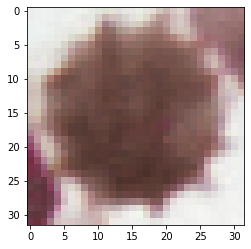

In [46]:
plt.imshow(train_df['image'][0])

In [47]:
class MalariaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.n_samples = len(dataframe)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        image = self.dataframe['image'][index]
        label = self.dataframe['label'][index]
        if self.transform: 
            image = self.transform(image)
        return image, label

In [154]:
df = pd.read_pickle('./cv_cnn/cropped_balanced.pickle')

In [155]:
n = len(df)
print(n)

4298


In [156]:
df

,image,label
0,"[[[235, 238, 236], [235, 238, 236], [235, 238,...",1
1,"[[[228, 228, 222], [229, 230, 220], [233, 232,...",1
2,"[[[231, 234, 225], [230, 231, 223], [230, 231,...",1
3,"[[[216, 206, 197], [218, 209, 199], [221, 211,...",0
4,"[[[235, 234, 236], [235, 234, 236], [235, 234,...",0
...,...,...
4293,"[[[225, 229, 224], [225, 229, 224], [225, 229,...",0
4294,"[[[224, 230, 225], [228, 233, 231], [228, 233,...",1
4295,"[[[226, 235, 232], [230, 240, 234], [225, 235,...",0
4296,"[[[221, 229, 226], [221, 229, 226], [221, 229,...",1


In [157]:
train_set = MalariaDataset(df[:3000], transform=transform)
val_set = MalariaDataset(df[3000:4000].reset_index(drop=True), transform=transform)
test_set = MalariaDataset(df[4000:].reset_index(drop=True), transform=transform)

In [135]:
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(3, 6, 5), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 10, 5), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fcs = nn.Sequential(
            nn.Linear(10 * 5 * 5, 512),
            nn.ReLU(),
            nn.Linear(512, 64), 
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, x): 
        output = self.convs(x)
        # print(output.size())
        output = output.view(-1, 10 * 5 * 5)
        output = self.fcs(output)
        return output

In [50]:
model_path = pathlib.Path(f"./cv_cnn/cnn_bs1")
model_path.mkdir(parents=True, exist_ok=True)

In [130]:
def evaluate(model, loader): 
    total_err = 0
    total_samples = 0
    for images, labels in loader: 
        outputs = model(images)
        correct = (outputs > 0.0).squeeze().long() != labels
        total_err += int(correct.sum())
        total_samples += len(labels)
    return float(total_err) / total_samples

In [158]:
len(train_set)

3000

In [144]:
def train(model=None, batch_size=32, learning_rate=0.001, num_epochs = 10):    
    torch.manual_seed(1000)
    model_path = pathlib.Path(f"./cv_cnn/cnn_bs{batch_size}_lr{learning_rate}")
    model_path.mkdir(parents=True, exist_ok=True) # make directory
    
    if model is None:
        model = CNN()
        
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # model.cuda()
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    n = len(train_loader)

    for epoch in range(num_epochs):
        epoch_loss = 0 
        for images, labels in train_loader: 
            labels = labels.unsqueeze(1).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        train_loss[epoch] = epoch_loss / n
        train_err[epoch] = evaluate(model, train_loader)
        val_err[epoch] = evaluate(model, val_loader)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {train_loss[epoch]:.4f}, train Error: {train_err[epoch]:.4f}, val Error: {val_err[epoch]:.4f}")
        torch.save(model.state_dict(), model_path / f"epoch_{epoch}")

    return model_path

In [159]:
train()

Epoch 0/10, Loss: 0.4441, train Error: 0.0759, val Error: 0.0706
Epoch 1/10, Loss: 0.1884, train Error: 0.0575, val Error: 0.0383
Epoch 2/10, Loss: 0.2077, train Error: 0.0709, val Error: 0.0766
Epoch 3/10, Loss: 0.1712, train Error: 0.0528, val Error: 0.0393
Epoch 4/10, Loss: 0.1640, train Error: 0.0501, val Error: 0.0454
Epoch 5/10, Loss: 0.1716, train Error: 0.0440, val Error: 0.0413
Epoch 6/10, Loss: 0.1459, train Error: 0.0447, val Error: 0.0403
Epoch 7/10, Loss: 0.1436, train Error: 0.0652, val Error: 0.0444
Epoch 8/10, Loss: 0.1421, train Error: 0.0642, val Error: 0.0605
Epoch 9/10, Loss: 0.1259, train Error: 0.0551, val Error: 0.0383


PosixPath('cv_cnn/cnn_bs32_lr0.001')

In [65]:
train()

Epoch 0/10, Loss: 0.4526, train Error: 0.1250
Epoch 1/10, Loss: 0.2519, train Error: 0.0858
Epoch 2/10, Loss: 0.2015, train Error: 0.0661
Epoch 3/10, Loss: 0.1914, train Error: 0.0563
Epoch 4/10, Loss: 0.1927, train Error: 0.0778
Epoch 5/10, Loss: 0.2081, train Error: 0.0541
Epoch 6/10, Loss: 0.1502, train Error: 0.0527
Epoch 7/10, Loss: 0.1523, train Error: 0.0512
Epoch 8/10, Loss: 0.1465, train Error: 0.0727
Epoch 9/10, Loss: 0.1473, train Error: 0.0654


PosixPath('cv_cnn/cnn_bs32_lr0.001')

# eval

In [92]:
model = CNN()
state = torch.load('./cv_cnn/cnn_bs32_lr0.001/epoch_9')
model.load_state_dict(state)

<All keys matched successfully>

In [160]:
MAX_ERROR = 8.0
def find_label(output_box, targets, labels): 
    min_label = None
    min_error = float("inf")
    for box, label in zip(targets, labels):
        error = sum((box[i] - output_box[i])**2 for i in range(4)).item()
        if error < min_error: 
            min_error = error
            min_label = label
    if min_error > MAX_ERROR: 
        return None
    return min_label

In [161]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((32,32))])

def eval_detection(cnn, start=845): 
    total_correct = 0
    total_samples = 0
    for i in range(start, len(df1)):
        img = cv2.imread(rootpath + df1['path'][i])
        # print(img.shape)
        img = transforms.ToTensor()(img)
        outputs = try_image(i) # detection 
        
        targets = df1['objects'][i]['boxes']
        labels = df1['objects'][i]['labels']
        
        for box in outputs:
            label = find_label(box, targets) 
            if label is None:
                continue
            cropped = img[:, box[1]:box[3], box[0]:box[2]]
            if cropped.shape[1]*cropped.shape[2]<= 0:
                continue
            cropped = transforms.Resize((32,32))(cropped).unsqueeze(0)
            cnn_out = cnn(cropped)
            print(cnn_out)
            total_correct += ((cnn_out > 0.0) == label)
            total_samples += 1
    return float(total_correct) / total_samples

i = 1200
tensor(1, dtype=torch.int8)
tensor([[-3.1952]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.7136]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-4.8182]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-1.7641]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.7125]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor([[-2.0672]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.5308]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.4436]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.3715]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-4.8803]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.0649]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.8272]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.7844]], grad_fn=<AddmmBackward0>)
t

tensor([[-5.8124]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.2602]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor([[0.2196]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-4.7079]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.2875]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-5.3043]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-0.2963]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-1.2354]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-7.5124]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[1.9546]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-4.9563]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-6.5494]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-6.4684]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.

i = 1203
tensor(1, dtype=torch.int8)
tensor([[-2.0219]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-0.8297]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.6774]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.2594]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor([[-0.7794]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-0.2624]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-0.6177]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.6461]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.0709]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.9995]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-1.0543]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.3427]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.1968]], grad_fn=<AddmmBackward0>)
t

tensor(1, dtype=torch.int8)
tensor([[-2.7672]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-1.1239]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.7239]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-6.4300]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-4.5450]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[2.4043]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-4.3231]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.6680]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-1.5398]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.8483]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.6106]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-4.6202]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-0.4685]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-7

tensor([[-4.3580]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.7365]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-4.0868]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.0178]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.7133]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.8809]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor(1, dtype=torch.int8)
tensor([[-4.2001]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.8804]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.4001]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.7018]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.4205]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-3.5032]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-2.5773]], grad_fn=<AddmmBackward0>)
tensor(1, dtype=torch.int8)
tensor([[-

0.950592885375494

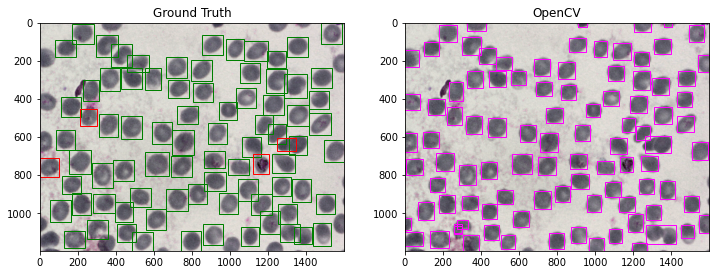

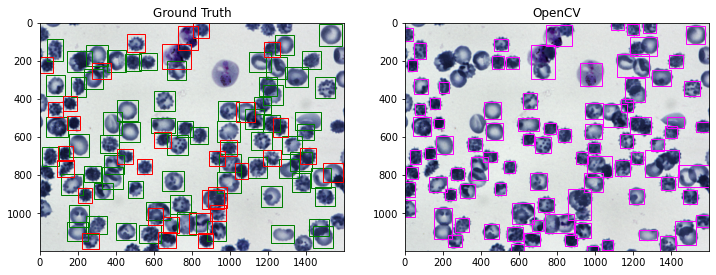

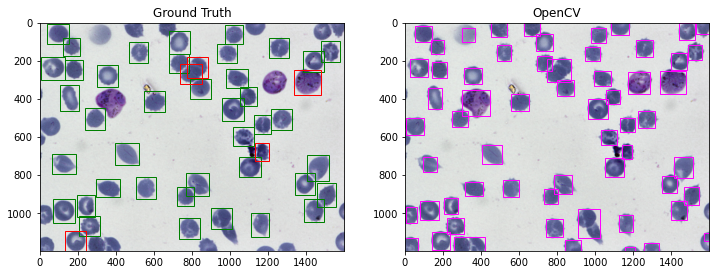

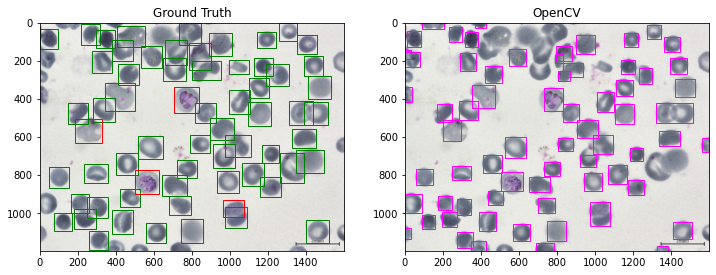

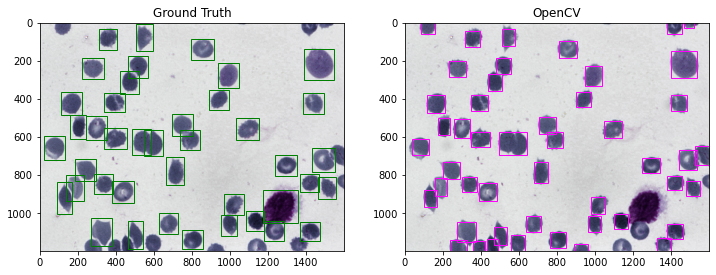

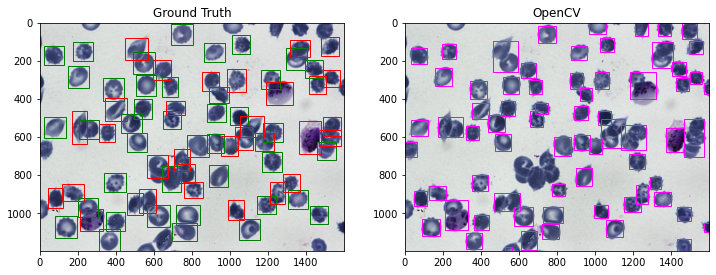

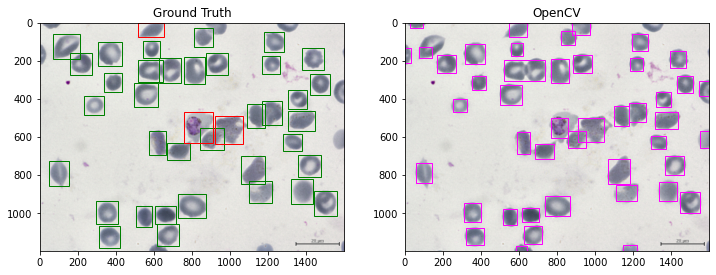

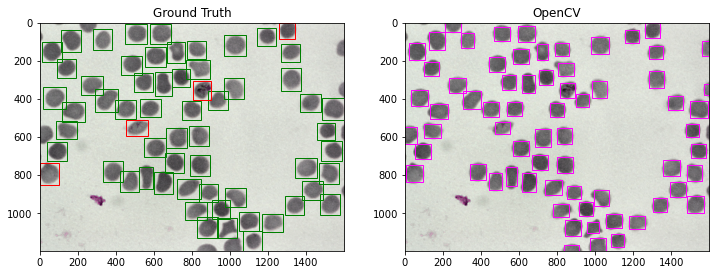

In [132]:
eval_detection(model, 1200)

# fold

In [78]:
im.shape

torch.Size([3, 100, 104])

In [79]:
df1['objects'][i]['boxes'][0]

array([1046,  995, 1150, 1095])

In [72]:
df1.head()

,image,objects,path,shape
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"{'boxes': [[1440, 1057, 1540, 1158], [1303, 86...",/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"(1200, 1600, 3)"
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"{'boxes': [[735, 734, 834, 832], [1283, 939, 1...",/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,"(1200, 1600, 3)"
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"{'boxes': [[1027, 724, 1136, 834], [1155, 287,...",/images/6b14c855-8561-417c-97a4-63fa552842fd.png,"(1200, 1600, 3)"
3,{'checksum': '8a111dffacfa433029492780b9535091...,"{'boxes': [[1421, 563, 1545, 656], [324, 208, ...",/images/13099edb-35d9-438f-b093-2cf2ebf9d255.png,"(1200, 1600, 3)"
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"{'boxes': [[688, 618, 810, 744], [1035, 689, 1...",/images/2559636b-f01a-4414-93da-210c3b12d153.png,"(1200, 1600, 3)"


tensor([[[[0.9216, 0.9294, 0.9333,  ..., 0.6196, 0.6118, 0.6392],
          [0.9216, 0.9294, 0.9333,  ..., 0.6275, 0.6157, 0.6235],
          [0.9255, 0.9294, 0.9294,  ..., 0.6000, 0.6000, 0.5804],
          ...,
          [0.4314, 0.4000, 0.3882,  ..., 0.9412, 0.9451, 0.9490],
          [0.3647, 0.3765, 0.3961,  ..., 0.9490, 0.9529, 0.9412],
          [0.4235, 0.4000, 0.4588,  ..., 0.9490, 0.9608, 0.9569]],

         [[0.9333, 0.9412, 0.9451,  ..., 0.4824, 0.4706, 0.4941],
          [0.9333, 0.9412, 0.9451,  ..., 0.4745, 0.4588, 0.4667],
          [0.9412, 0.9451, 0.9412,  ..., 0.4510, 0.4510, 0.4353],
          ...,
          [0.2588, 0.2392, 0.2275,  ..., 0.9451, 0.9490, 0.9529],
          [0.2235, 0.2078, 0.2157,  ..., 0.9529, 0.9569, 0.9451],
          [0.2118, 0.1961, 0.2392,  ..., 0.9529, 0.9647, 0.9608]],

         [[0.9255, 0.9333, 0.9373,  ..., 0.4902, 0.4824, 0.4980],
          [0.9255, 0.9333, 0.9373,  ..., 0.4784, 0.4667, 0.4706],
          [0.9333, 0.9373, 0.9333,  ..., 0

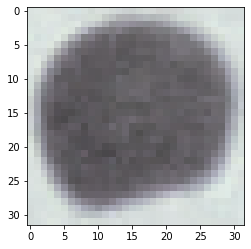

In [86]:
loader1 = DataLoader(train_set, batch_size=1, shuffle=False, drop_last=True)
for img, lbl in loader1:
    print(img)
    plt.imshow(np.transpose(np.array(im), (1,2,0)))
    break

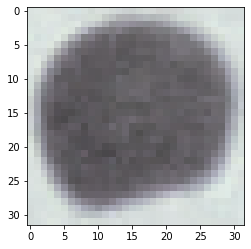

In [87]:
transform = transforms.Compose([transforms.ToTensor()])
img = cv2.imread(rootpath + df1['path'][i])
box = df1['objects'][i]['boxes'][0]

cropped = img[box[1]:box[3], box[0]:box[2], :]
cropped = resize(cropped, (32,32)) 
im = transform(cropped)
plt.imshow(np.transpose(np.array(im), (1,2,0)))

In [129]:
def evaluate(model, loader): 
    total_err = 0
    total_samples = 0
    for images, labels in loader: 
        print(labels)
        outputs = model(images)
        print(outputs)
        correct = (outputs > 0.0).squeeze().long() != labels
        total_err += int(correct.sum())
        total_samples += len(labels)
    return float(total_err) / total_samples

evaluate(model, loader1)

tensor([1])
tensor([[0.9952]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.3771]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.2607]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.1469]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.9303]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-3.9719]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.8572]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.1237]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.8405]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-1.2100]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.5296]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.2705]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.0144]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.3713]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.9313]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.0742]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.0439]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.

tensor([[-4.6205]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.7359]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.2705]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.4091]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.1244]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.0729]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.1214]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.7495]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.0508]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.7979]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.4823]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.7212]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.6686]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.3564]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.7441]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.3220]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.1235]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.1534]], gr

tensor([[5.5472]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[5.9972]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.5893]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-0.5322]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.4287]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-1.5016]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.8501]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.1765]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.0348]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.2097]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.3776]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.8801]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.9332]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.8407]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.2508]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.6443]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.3751]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.1795]], gra

tensor([[1.7146]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-10.8831]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.0609]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.3738]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.7368]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.4894]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.0333]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.9831]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.9172]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.6134]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.8310]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.9640]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.1901]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-2.3345]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.4419]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.5367]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.7229]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.9506]], gra

tensor([[2.1508]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.5656]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.5396]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.1231]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.4540]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.5276]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.7191]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.5089]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.3545]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.6632]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.6492]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.0706]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.3293]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.7727]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.6415]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.2762]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-10.6771]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.5791]], 

tensor([[0.6970]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.8708]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-1.8967]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-3.1957]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-1.1543]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-10.4115]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.3318]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.5897]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.8983]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.1595]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.4753]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.3686]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.6865]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.2665]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.8524]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.1436]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.3357]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-12.0005]],

tensor([[-5.5130]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.6661]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[5.9408]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.8164]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.6534]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.7418]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.4378]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.2238]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.9671]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.9241]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.2839]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.2165]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.4720]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.4222]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.5559]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.5335]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.4671]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.3780]], gr

tensor([[-10.0087]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.8346]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.1127]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[5.6804]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.9236]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.5309]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.1571]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.4458]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.1836]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.1947]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.4674]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.7639]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.3351]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-2.4048]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.6608]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-4.1432]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.2007]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.2878]],

tensor([[5.8283]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.5918]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.5647]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.0857]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.0082]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.6838]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.7151]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.3911]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.4425]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.2282]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.0444]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.3688]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.8229]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.6432]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[7.6945]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.1196]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.9869]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.9648]], g

tensor([[-5.7910]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.4638]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.7140]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.1903]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.9691]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-3.3663]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-3.4602]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.6841]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[5.7485]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.5385]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.3861]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.0287]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.1688]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.3964]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.8782]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.2413]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.7736]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.5807]], 

tensor([0])
tensor([[-3.8806]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.6505]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.9769]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.6018]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.1087]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.1268]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.1488]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-3.0486]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.9327]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.0305]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.9109]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.7358]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-1.0147]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-10.5115]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.5861]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.3209]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-1.9127]], grad_fn=<AddmmBackward0>)
tensor([1])
tens

tensor([1])
tensor([[4.3736]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.9155]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-0.1653]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-1.9477]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.8982]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.9367]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[5.5339]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.2128]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.4831]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.6878]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.4578]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[0.4469]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.6984]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.1045]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.0961]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.3216]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.1303]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.

tensor([[2.8344]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.8785]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.1933]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.1778]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.0019]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.4181]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.1862]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[6.4452]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.1645]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.4057]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.6554]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.9327]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.5461]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[5.4304]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.5849]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.4166]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.5491]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-10.8485]], gr

tensor([[1.4360]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.2906]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.7728]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.6089]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.4505]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.6241]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[5.5372]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.8968]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.8874]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.4941]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-0.6629]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.4390]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.1564]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.9497]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.8318]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.1276]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.6058]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.0113]], gra

tensor([[-8.7725]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.2695]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.8277]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.0007]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-1.3868]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-13.6575]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.4303]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.1544]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.3159]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.6191]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-9.6718]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.3176]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.8371]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-2.6238]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[1.1572]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.5974]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.0174]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.7559]],

tensor([[-11.6165]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.4779]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.0941]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-10.6159]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.1695]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.6704]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.9810]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.5569]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.0224]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.8649]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.3629]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[4.8349]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-11.1859]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.5154]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.5285]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.4186]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.5735]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.0149]

tensor([[4.3872]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.9243]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.1253]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.2700]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.9160]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.8626]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-3.9351]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.9615]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-3.9240]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.2759]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-4.0949]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.7099]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-13.7360]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.7195]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.8954]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.3100]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[3.6019]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-2.9850]], g

tensor([1])
tensor([[-0.4529]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.4565]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.6452]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-8.2058]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.6185]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-0.3903]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-3.4816]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-5.9288]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[1.0610]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.9778]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[-2.9953]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-7.5069]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.2435]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.7114]], grad_fn=<AddmmBackward0>)
tensor([1])
tensor([[2.3861]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-6.4254]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([[-1.3206]], grad_fn=<AddmmBackward0>)
tensor([0])
tensor([

0.06520172910662825